In [96]:
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs, make_classification
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode
from scipy.special import expit

In [2]:
import pymc3 as pm

In [3]:
# bayesian clustering with noise
# we model 2 the behaviour of two asessors which can randomly make mistakes when classifying data

In [22]:
X, Z = make_blobs(n_samples=1000, n_features = 2, centers=2, cluster_std=0.5)
#Z = (~np.c_[Z, ~Z.astype(bool)].astype(bool)).astype(float)

In [23]:
X = np.c_[X, np.ones_like(X[:, 1])]

In [47]:
#A = np.array([0.1, 0.3, 0.2]) # asessor
W = np.array([
    [-.5, -0.8, -1],
    [0, -.5, 0.1]
])

nu = 1 / (1+np.exp(-(X @ W.T)))

In [ ]:
# probability that k-th assessor will make mistake at i-th sample

In [49]:
nu

array([[0.91152454, 0.32685499],
       [0.868164  , 0.33460453],
       [0.99922268, 0.86968304],
       ...,
       [0.99892994, 0.872298  ],
       [0.9990839 , 0.87611959],
       [0.99827347, 0.82226366]])

In [50]:
Y = np.random.binomial(1, nu)

In [ ]:
# generating asessors predictions

In [51]:
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        if Y[i][j] == 1:
            Y[i][j] = Z[i]
        else:
            Y[i][j] = 1 - Z[i]
    

In [ ]:
# model from http://proceedings.mlr.press/v9/yan10a/yan10a.pdf

In [70]:
with pm.Model() as model:
    w1 = pm.MvNormal('w1', mu=np.array([-.5, -0.8, -1]), cov=np.eye(3), shape=(1, 3))
    w2 = pm.MvNormal('w2', mu=np.array([0, -.5, 0.1]), cov=np.eye(3), shape=(1, 3))
    
    z_coef = pm.MvNormal('z_coef', mu=np.array([0, 0, 0]), cov=np.eye(3), shape=(1, 3))
    z = pm.Bernoulli('z', p=pm.math.sigmoid(pm.math.dot(z_coef, X.T)), shape=(1, 1000))
    
    c1 = 1 - pm.math.abs_(z - Y[:,0])
    c2 = 1 - pm.math.abs_(z - Y[:,1])

    y1 = pm.Bernoulli('y1', p=pm.math.sigmoid(pm.math.dot(w1, X.T)), observed=c1)
    y2 = pm.Bernoulli('y2', p=pm.math.sigmoid(pm.math.dot(w2, X.T)), observed=c2)
    
    trace = pm.sample(progressbar=True, draws=500)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [z_coef, w2, w1]
>BinaryGibbsMetropolis: [z]
Sampling 4 chains: 100%|██████████| 4000/4000 [07:37<00:00,  2.16draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
# posterior over parameters of ground predictions

/Users/ppogorelov/VirtualEnv/v2/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1372077f0>,
      dtype=object)

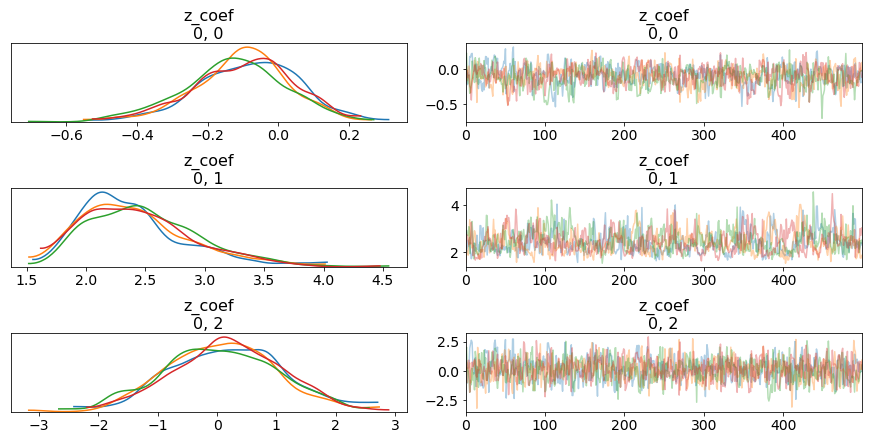

In [107]:
pm.traceplot(varnames=['z_coef'], data=trace)

In [ ]:
# averaging posteriors

In [95]:
z_coef = np.array([
    np.mean(np.squeeze(trace['z_coef'])[:, 0]),
    np.mean(np.squeeze(trace['z_coef'])[:, 1]),
    np.mean(np.squeeze(trace['z_coef'])[:, 2])
])

In [ ]:
# accuracy = 1.0

In [106]:
np.sum((expit(z_coef @ X.T) > .5).astype(int) == Z) / Z.shape[0]

1.0